In [5]:
from dfLoader import *
from dataAug import *
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import random


In [36]:
annAudioDic = {
    'BritishBatCalls_MartynCooke_2018_1_sec_train_expert.json':'bat_data_martyn_2018/',
    'BritishBatCalls_MartynCooke_2018_1_sec_test_expert.json':'bat_data_martyn_2018_test/',
    'BritishBatCalls_MartynCooke_2019_1_sec_test_expert.json':'bat_data_martyn_2019_test/',
    'BritishBatCalls_MartynCooke_2019_1_sec_train_expert.json':'bat_data_martyn_2019/',
    'bcireland_expert.json':'bcireland/',
    'sn_scot_nor_0.5_expert.json':'sn_scot_nor/',
    'Echobank_train_expert.json':'echobank/',
    'BCT_1_sec_train_expert.json':'BCT_1_sec/'
}

testAudioDic = {
    'BritishBatCalls_MartynCooke_2018_1_sec_train_expert.json':'bat_data_martyn_2018/',
    'BritishBatCalls_MartynCooke_2018_1_sec_test_expert.json':'bat_data_martyn_2018_test/',
    'BritishBatCalls_MartynCooke_2019_1_sec_test_expert.json':'bat_data_martyn_2019_test/',
    'BritishBatCalls_MartynCooke_2019_1_sec_train_expert.json':'bat_data_martyn_2019/'
}


trainAudioDic = {
    'bcireland_expert.json':'bcireland/',
    'sn_scot_nor_0.5_expert.json':'sn_scot_nor/',
    'Echobank_train_expert.json':'echobank/',
    'BCT_1_sec_train_expert.json':'BCT_1_sec/'
}

classesDic = {
    'Myotis daubentonii': 0,
    'Plecotus auritus': 1,
    'Pipistrellus pipistrellus': 2,
    # 'Bat': 3,
    'Nyctalus leisleri': 3,
    'Pipistrellus pygmaeus': 4,
    'Myotis mystacinus': 5,
    'Myotis nattereri': 6,
    'Pipistrellus nathusii': 7,
    'Nyctalus noctula': 8,
    'Eptesicus serotinus': 9,
    'Barbastellus barbastellus': 10,
    'Myotis brandtii': 11,
    'Myotis alcathoe': 12,
    'Myotis bechsteinii': 13,
    'Plecotus austriacus': 14,
    'Rhinolophus ferrumequinum': 15,
    'Rhinolophus hipposideros': 16
 }


def dfLoader(ann_path, audio_dir, allData):

    # Load annotation and convert to dataframe
    data = json.load(open(ann_path))
    df = pd.json_normalize(data, record_path=['annotation'], meta=['id'])

    if(not allData):
        df = df[df['class'] != 'Bat']

    trimInTime, trimOutTime = calInOutTime(df)
    df['trimInTime'] = trimInTime
    df['trimOutTime'] = trimOutTime

    trimmed_specs = trimAudio(df, audio_dir)
    df['data'] = trimmed_specs

    specLength = []
    for index, row in df.iterrows():
        specLength.append(row['data'].shape[1])
    df['len'] = specLength

    # Delete data shorter than 20 ms
    df = df[df['len'] ==32]

    if(not allData):
        numLabels = addNumLabels(df)
        df['label'] = numLabels

    resizedSpecs = reSizeSpec(df)
    df['data'] = resizedSpecs

    return df

In [3]:
def getDataLoader(audioDic):

    dfList = []

#     if ifTrain:
#         audioDic = trainAudioDic
#     else:
#         audioDic = testAudioDic

    for annName in audioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + audioDic[annName]
        df = dfLoader(annPath, audioPath,False)
        dfList.append(df)

    finalDF = pd.concat(dfList)
    return finalDF

In [4]:
all_DF = getDataLoader(annAudioDic)
# train_DF = getDataLoader(trainAudioDic)
# test_DF = getDataLoader(testAudioDic)

# File based train/test splite

In [ ]:
for annName in audioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + audioDic[annName]
        df = dfLoader(annPath, audioPath, allData = False)
        noises = getNoiseList(df, audioPath, 300)
        noiseList.extend(noises)

In [32]:
def genNoiseList(noiseCount):

    noiseList = []

    for annName in annAudioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + annAudioDic[annName]
        df = dfLoader(annPath, audioPath, allData = False)
        noises = getNoiseList(df, audioPath, int(noiseCount/8))
        noiseList.extend(noises)

    return noiseList

In [73]:
dataAug = False
batchSize = 32

classNumDic = {}
for index, value in all_DF['class'].value_counts().items():
    classNumDic[index] = value * 0.75

classNumDicDS = {}
dataCount = 302

for i in classes:
    classNumDicDS[i] = dataCount
    
classDataDic = {}

X_train = []
y_train = []

X_test = []
y_test = []


for file in all_DF['id'].unique():
    curr_df = all_DF[(all_DF['id'] == file)]
    for index, row in curr_df.iterrows(): 

        if(classNumDic[row['class']] > 0):

            train_files.append(file)

            if(classNumDicDS[row['class']] > 0):

                X_train.append(row['data'])
                y_train.append(row['label'])
                classNumDicDS[row['class']] = classNumDicDS[row['class']]-1

            classNumDic[row['class']] = classNumDic[row['class']]-1
        else:
            X_test.append(row['data'])
            y_test.append(row['label'])
            
noiseList = genNoiseList(dataCount)
X_train.extend(noiseList)
y_train.extend([17]*len(noiseList))

X_train = torch.Tensor(np.array(X_train))
y_train = torch.Tensor(np.array(y_train))

X_test = torch.Tensor(np.array(X_test))
y_test = torch.Tensor(np.array(y_test))

if dataAug:
    augData = genAugData(X_train,3)
    print(f'Data Aug size is {augData.size()}')

    X_train = torch.concat((X_train,augData))
    y_train = torch.concat((y_train,y_train,y_train,y_train))

datasetTensor = TensorDataset(X_train,y_train)
trainLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)

datasetTensor = TensorDataset(X_test,y_test)
testLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)


In [77]:
len(y_test)

7810

In [80]:
for i in range(17):
    print(f'number of sample of class {i} is {y_test.tolist().count(i)}')

number of sample of class 0 is 1584
number of sample of class 1 is 280
number of sample of class 2 is 472
number of sample of class 3 is 287
number of sample of class 4 is 586
number of sample of class 5 is 689
number of sample of class 6 is 656
number of sample of class 7 is 360
number of sample of class 8 is 100
number of sample of class 9 is 646
number of sample of class 10 is 246
number of sample of class 11 is 484
number of sample of class 12 is 216
number of sample of class 13 is 220
number of sample of class 14 is 210
number of sample of class 15 is 409
number of sample of class 16 is 365


In [50]:
myset2 = set(train_files)
print(len(myset2))

1918


In [51]:
myset2 == myset

True

In [52]:
len(X_train)

5134

In [53]:
len(X_test)

7810

In [35]:
myset = set(train_files)
print(len(myset))

1918


In [ ]:
for i in classes:
    classNumDic[i] = dataCount

classNumDic = {}
for index, value in all_DF['class'].value_counts().items():
    classNumDic[index] = value * 0.75

In [34]:
dataAug = True
batchSize = 32
dataCount = 302


def genTrainTestLoader(batchSize, dataAug, dataCount, testAmount):

    classNumDic = {}
    for index, value in all_DF['class'].value_counts().items():
        classNumDic[index] = value * (1-testAmount)

    classNumDicDS = {}
    classDataDic = {}

    for i in classes:
        classNumDicDS[i] = dataCount

    X_train = []
    y_train = []

    X_test = []
    y_test = []


    for file in all_DF['id'].unique():
        curr_df = all_DF[(all_DF['id'] == file)]
        for index, row in curr_df.iterrows(): 
            
            rowClass = row['class']

            if(classNumDic[row['class']] > 0):

                
                if rowClass in classDataDic:
#                     print(rowClass)
#                     print(rowClass in classDataDic)
#                     print(len(classDataDic[rowClass]))
                    currClassData = classDataDic[rowClass].append(row['data'])
#                     classDataDic[rowClass] = currClassData
                else:
                    classDataDic[rowClass] = [row['data']]

#                 if(classNumDicDS[row['class']] > 0):

#                     X_train.append(row['data'])
#                     y_train.append(row['label'])
#                     classNumDicDS[row['class']] = classNumDicDS[row['class']]-1

                classNumDic[row['class']] = classNumDic[row['class']]-1
            else:
                X_test.append(row['data'])
                y_test.append(row['label'])
                
    for key in classDataDic:
        sampled_class_data = random.sample(classDataDic[key], dataCount)
        X_train.extend(sampled_class_data)
        y_train.extend([key]*dataCount)

    noiseList = genNoiseList(dataCount)
    X_train.extend(noiseList)
    y_train.extend([17]*len(noiseList))

    X_train = torch.Tensor(np.array(X_train))
    y_train = torch.Tensor(np.array(y_train))

    X_test = torch.Tensor(np.array(X_test))
    y_test = torch.Tensor(np.array(y_test))
    
    
    print(len(X_train))
    print(len(y_train))

    for i in range(17):
        print(f'number of sample of class {i} is {y_test.tolist().count(i)}')

    for i in range(17):
        print(f'number of sample of class {i} is {y_train.tolist().count(i)}')


    if dataAug:
        augData = genAugData(X_train,3)
        print(f'Data Aug size is {augData.size()}')

        X_train = torch.concat((X_train,augData))
        y_train = torch.concat((y_train,y_train,y_train,y_train))

    datasetTensor = TensorDataset(X_train,y_train)
    trainLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)

    datasetTensor = TensorDataset(X_test,y_test)
    testLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)
    
    return trainLoader, testLoader


In [35]:
genTrainTestLoader(batchSize = 32, dataAug = False, dataCount = 302, testAmount = 0.25)

TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [48]:
def genAllDataFrame(audioDic):
    dfList = []

    for annName in audioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + audioDic[annName]
        df = dfLoader(annPath, audioPath,False)
        dfList.append(df)

    all_DF = pd.concat(dfList)

    return all_DF

def genNoiseList(noiseCount):

    noiseList = []

    for annName in annAudioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + annAudioDic[annName]
        df = dfLoader(annPath, audioPath, allData = False)
        noises = getNoiseList(df, audioPath, int(noiseCount/8))
        noiseList.extend(noises)

    return noiseList

def genTrainTestLoader(batchSize, dataAug, dataCount, testAmount):

    
    all_DF = genAllDataFrame(annAudioDic)

    classNumDic = {}
    for index, value in all_DF['class'].value_counts().items():
        classNumDic[index] = value * (1-testAmount)

    classNumDicDS = {}

    for i in classes:
        classNumDicDS[i] = dataCount
        
    classDataDic = {}

    X_train = []
    y_train = []

    X_test = []
    y_test = []
    
    
    train_files = []
    
    files = all_DF['id'].unique()
    
    random.shuffle(files)
    for file in files:
        curr_df = all_DF[(all_DF['id'] == file)]
        train_files.append(file)

        for index, row in curr_df.iterrows(): 
            
            rowClass = row['class']
            
            if(classNumDic[rowClass] > 0):
                
                if rowClass in classDataDic:
                    
                    classDataDic[rowClass].append(row['data'])
                else:
                    classDataDic[rowClass] = [row['data']]

#                 if(classNumDicDS[rowClass] > 0):

#                     X_train.append(row['data'])
#                     y_train.append(row['label'])
#                     classNumDicDS[rowClass] = classNumDicDS[rowClass]-1

                classNumDic[rowClass] = classNumDic[rowClass]-1
            else:
                X_test.append(row['data'])
                y_test.append(row['label'])
                
    for key in classDataDic:
        sampled_class_data = random.sample(classDataDic[key], dataCount)
        X_train.extend(sampled_class_data)
        y_train.extend([classesDic[key]]*dataCount)
        

    noiseList = genNoiseList(dataCount)
    X_train.extend(noiseList)
    y_train.extend([17]*len(noiseList))

    X_train = torch.Tensor(np.array(X_train))
    y_train = torch.Tensor(np.array(y_train))

    X_test = torch.Tensor(np.array(X_test))
    y_test = torch.Tensor(np.array(y_test))

#     print(len(X_train))
#     print(len(y_train))

#     for i in range(17):
#         print(f'number of sample of class {i} is {y_test.tolist().count(i)}')

#     for i in range(17):
#         print(f'number of sample of class {i} is {y_train.tolist().count(i)}')

#     if dataAug:
#         augData = genAugData(X_train,3)
#         print(f'Data Aug size is {augData.size()}')

        X_train = torch.concat((X_train,augData))
        y_train = torch.concat((y_train,y_train,y_train,y_train))

    datasetTensor = TensorDataset(X_train,y_train)
    trainLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)

    datasetTensor = TensorDataset(X_test,y_test)
    testLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)
    
#     print(train_files)
    
    return trainLoader, testLoader


In [49]:
genTrainTestLoader(batchSize = 32, dataAug = False, dataCount = 302, testAmount = 0.25)

5430
5430
number of sample of class 0 is 1584
number of sample of class 1 is 280
number of sample of class 2 is 472
number of sample of class 3 is 287
number of sample of class 4 is 586
number of sample of class 5 is 689
number of sample of class 6 is 656
number of sample of class 7 is 360
number of sample of class 8 is 100
number of sample of class 9 is 646
number of sample of class 10 is 246
number of sample of class 11 is 484
number of sample of class 12 is 216
number of sample of class 13 is 220
number of sample of class 14 is 210
number of sample of class 15 is 409
number of sample of class 16 is 365
number of sample of class 0 is 302
number of sample of class 1 is 302
number of sample of class 2 is 302
number of sample of class 3 is 302
number of sample of class 4 is 302
number of sample of class 5 is 302
number of sample of class 6 is 302
number of sample of class 7 is 302
number of sample of class 8 is 302
number of sample of class 9 is 302
number of sample of class 10 is 302
n

(<torch.utils.data.dataloader.DataLoader at 0x7f9752e37760>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9752e373d0>)

# Total Data Check

In [5]:
classes = ['Myotis daubentonii', 'Plecotus auritus', 'Pipistrellus pipistrellus' , #'Bat',
 'Nyctalus leisleri' ,'Pipistrellus pygmaeus', 'Myotis mystacinus',
 'Myotis nattereri', 'Pipistrellus nathusii', 'Nyctalus noctula',
 'Eptesicus serotinus', 'Barbastellus barbastellus', 'Myotis brandtii',
 'Myotis alcathoe' ,'Myotis bechsteinii', 'Plecotus austriacus',
 'Rhinolophus ferrumequinum', 'Rhinolophus hipposideros','noise']


In [60]:
def getDataLoader(batchSize,ifAug,ifTrain):

    noiseList = []
    dfList = []

    if ifTrain:
        audioDic = trainAudioDic
    else:
        audioDic = testAudioDic

    for annName in audioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + audioDic[annName]
        df = dfLoader(annPath, audioPath, allData = False)
        noises = getNoiseList(df, audioPath, 300)
        noiseList.extend(noises)
        dfList.append(df)
        break

#     finalDF = pd.concat(dfList)
#     # print(finalDF['class'].unique())
#     dataLoader = genDataLoader(batchSize,finalDF,ifAug, noiseList)
    return df


In [61]:
df

NameError: name 'df' is not defined

In [62]:
df = getDataLoader(32,False, True)

In [31]:
df['label']

0       0
1       0
2       0
3       0
4       0
       ..
7873    1
7874    1
7875    1
7876    1
7877    1
Name: label, Length: 7750, dtype: int64

In [6]:
classNumDic = {}
dataCount = 200


for i in classes:
    classNumDic[i] = dataCount



In [35]:
X = []
y = []

for index, row in df.iterrows():
    if(classNumDic[row['class']] > 0):
        X.append(row['data'])
        y.append(row['label'])
        classNumDic[row['class']] = classNumDic[row['class']]-1

In [37]:
len(X)

1458

In [36]:
classNumDic

{'Myotis daubentonii': 0,
 'Plecotus auritus': 0,
 'Pipistrellus pipistrellus': 142,
 'Nyctalus leisleri': 0,
 'Pipistrellus pygmaeus': 0,
 'Myotis mystacinus': 0,
 'Myotis nattereri': 0,
 'Pipistrellus nathusii': 0,
 'Nyctalus noctula': 200,
 'Eptesicus serotinus': 200,
 'Barbastellus barbastellus': 200,
 'Myotis brandtii': 200,
 'Myotis alcathoe': 200,
 'Myotis bechsteinii': 200,
 'Plecotus austriacus': 200,
 'Rhinolophus ferrumequinum': 200,
 'Rhinolophus hipposideros': 200,
 'noise': 200}

In [10]:
len(classNumDic)

18

In [45]:
def getDataLoaderFilebase(batchSize,dataAug,ifTrain):

    noiseList = []
    dfList = []
    
    classNumDic = {}
    dataCount = 200
    
    

    for i in classes:
        classNumDic[i] = dataCount
        
    X = []
    y = []

    for annName in annAudioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + annAudioDic[annName]
        df = dfLoader(annPath, audioPath, allData = False)
        noises = getNoiseList(df, audioPath, 50)
        noiseList.extend(noises)
        


        for index, row in df.iterrows():
            if(classNumDic[row['class']] > 0):
                X.append(row['data'])
                y.append(row['label'])
                classNumDic[row['class']] = classNumDic[row['class']]-1
                
    X.extend(noiseList)
    y.extend([17]*len(noiseList))
    
    print(len(X))
    print(len(y))
    print(classNumDic)
            
    X = torch.Tensor(np.array(X))
    y = torch.Tensor(np.array(y))
    
    if dataAug:
        augData = genAugData(X,3)
        print(f'Data Aug size is {augData.size()}')

        X = torch.concat((X,augData))
        y = torch.concat((y,y,y,y))
    
    datasetTensor = TensorDataset(X,y)

    dataLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)

#     finalDF = pd.concat(dfList)
#     # print(finalDF['class'].unique())
#     dataLoader = genDataLoader(batchSize,finalDF,ifAug, noiseList)
    return dataLoader


In [46]:
getDataLoaderFilebase(32,False,False)

3800
3800
{'Myotis daubentonii': 0, 'Plecotus auritus': 0, 'Pipistrellus pipistrellus': 0, 'Nyctalus leisleri': 0, 'Pipistrellus pygmaeus': 0, 'Myotis mystacinus': 0, 'Myotis nattereri': 0, 'Pipistrellus nathusii': 0, 'Nyctalus noctula': 0, 'Eptesicus serotinus': 0, 'Barbastellus barbastellus': 0, 'Myotis brandtii': 0, 'Myotis alcathoe': 0, 'Myotis bechsteinii': 0, 'Plecotus austriacus': 0, 'Rhinolophus ferrumequinum': 0, 'Rhinolophus hipposideros': 0, 'noise': 200}


In [44]:
classNumDic

{'Myotis daubentonii': 0,
 'Plecotus auritus': 0,
 'Pipistrellus pipistrellus': 0,
 'Nyctalus leisleri': 0,
 'Pipistrellus pygmaeus': 0,
 'Myotis mystacinus': 0,
 'Myotis nattereri': 0,
 'Pipistrellus nathusii': 0,
 'Nyctalus noctula': 0,
 'Eptesicus serotinus': 0,
 'Barbastellus barbastellus': 0,
 'Myotis brandtii': 0,
 'Myotis alcathoe': 0,
 'Myotis bechsteinii': 0,
 'Plecotus austriacus': 0,
 'Rhinolophus ferrumequinum': 0,
 'Rhinolophus hipposideros': 0,
 'noise': 200}

## Split checking

In [32]:

def genDataLoader(batchSize, df, dataAug, noiseList):

    X = []
    y = []

    for index, row in df.iterrows():
        reshapeData = row['data']
        X.append(reshapeData)
        y.append(row['label'])

    X.extend(noiseList)
    y.extend([18]*len(noiseList))

    print(len(noiseList))

    X = torch.Tensor(np.array(X))
    y = torch.Tensor(np.array(y))


    return X,y

In [33]:
X, y = genDataLoader(20,train_DF,False, [])

0


In [36]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.50)


In [38]:
X_test.shape

torch.Size([8088, 128, 32])

In [20]:
mylist = list(set(y_train))
mylist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [28]:
for i in range((18)):
    print(y_train.count(i))

3212
442
678
468
571
1013
1057
2008
1157
167
344
353
264
288
200
256
245
217


In [30]:
for i in range((18)):
    print(y_test.count(i)*4)

3088
408
744
492
564
924
1132
2080
1140
132
348
296
332
308
220
260
256
220


In [21]:
mylist = list(set(y_test))
mylist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [68]:
classNames = []
for index, value in all_DF['class'].value_counts().items():
    classNames.append(index)
    print(f"Index : {index}, Value : {value}")

Index : Myotis daubentonii, Value : 6337
Index : Myotis mystacinus, Value : 2757
Index : Myotis nattereri, Value : 2627
Index : Eptesicus serotinus, Value : 2585
Index : Pipistrellus pygmaeus, Value : 2346
Index : Myotis brandtii, Value : 1936
Index : Pipistrellus pipistrellus, Value : 1891
Index : Rhinolophus ferrumequinum, Value : 1637
Index : Rhinolophus hipposideros, Value : 1460
Index : Pipistrellus nathusii, Value : 1442
Index : Bat, Value : 1389
Index : Nyctalus leisleri, Value : 1150
Index : Plecotus auritus, Value : 1120
Index : Barbastellus barbastellus, Value : 984
Index : Myotis bechsteinii, Value : 880
Index : Myotis alcathoe, Value : 866
Index : Plecotus austriacus, Value : 842
Index : Nyctalus noctula, Value : 402


In [69]:
classNames

['Myotis daubentonii',
 'Myotis mystacinus',
 'Myotis nattereri',
 'Eptesicus serotinus',
 'Pipistrellus pygmaeus',
 'Myotis brandtii',
 'Pipistrellus pipistrellus',
 'Rhinolophus ferrumequinum',
 'Rhinolophus hipposideros',
 'Pipistrellus nathusii',
 'Bat',
 'Nyctalus leisleri',
 'Plecotus auritus',
 'Barbastellus barbastellus',
 'Myotis bechsteinii',
 'Myotis alcathoe',
 'Plecotus austriacus',
 'Nyctalus noctula']

In [73]:
def seriesToList(series):
    classDic = {}
    for index, value in series.items():
        classDic[index] = value
    
    finalList = []
    
    for name in classNames:
        if name in classDic:
            finalList.append(classDic[name])
        else:
            finalList.append(0)
    
    return finalList

In [87]:
train_list = seriesToList(train_DF['class'].value_counts())

In [88]:
all_list = seriesToList(all_DF['class'].value_counts())

In [89]:
test_list = seriesToList(test_DF['class'].value_counts())

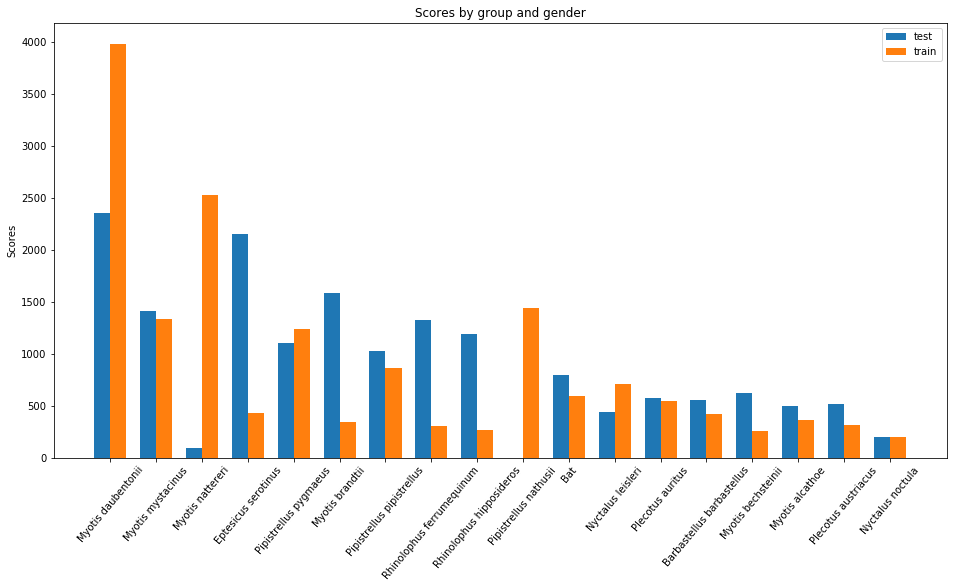

In [103]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = classNames
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width/2, test_list, width, label='test')
rects2 = ax.bar(x + width/2, train_list, width, label='train')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=50)
ax.legend()

## All data

In [33]:
all_DF['class'].value_counts()

Myotis daubentonii           6337
Myotis mystacinus            2757
Myotis nattereri             2627
Eptesicus serotinus          2585
Pipistrellus pygmaeus        2346
Myotis brandtii              1936
Pipistrellus pipistrellus    1891
Rhinolophus ferrumequinum    1637
Rhinolophus hipposideros     1460
Pipistrellus nathusii        1442
Bat                          1389
Nyctalus leisleri            1150
Plecotus auritus             1120
Barbastellus barbastellus     984
Myotis bechsteinii            880
Myotis alcathoe               866
Plecotus austriacus           842
Nyctalus noctula              402
Name: class, dtype: int64

## Test Data

In [34]:
test_DF['class'].value_counts()

Myotis daubentonii           2353
Eptesicus serotinus          2154
Myotis brandtii              1589
Myotis mystacinus            1417
Rhinolophus ferrumequinum    1328
Rhinolophus hipposideros     1188
Pipistrellus pygmaeus        1102
Pipistrellus pipistrellus    1027
Bat                           798
Myotis bechsteinii            625
Plecotus auritus              576
Barbastellus barbastellus     557
Plecotus austriacus           521
Myotis alcathoe               501
Nyctalus leisleri             438
Nyctalus noctula              202
Myotis nattereri               99
Name: class, dtype: int64

## With all four files

In [40]:
train_DF['class'].value_counts()

Myotis daubentonii           3984
Myotis nattereri             2528
Pipistrellus nathusii        1442
Myotis mystacinus            1340
Pipistrellus pygmaeus        1244
Pipistrellus pipistrellus     864
Nyctalus leisleri             712
Bat                           591
Plecotus auritus              544
Eptesicus serotinus           431
Barbastellus barbastellus     427
Myotis alcathoe               365
Myotis brandtii               347
Plecotus austriacus           321
Rhinolophus ferrumequinum     309
Rhinolophus hipposideros      272
Myotis bechsteinii            255
Nyctalus noctula              200
Name: class, dtype: int64

In [42]:
for index, value in train_DF['class'].value_counts().items():
    print(f"Index : {index}, Value : {value}")

Index : Myotis daubentonii, Value : 3984
Index : Myotis nattereri, Value : 2528
Index : Pipistrellus nathusii, Value : 1442
Index : Myotis mystacinus, Value : 1340
Index : Pipistrellus pygmaeus, Value : 1244
Index : Pipistrellus pipistrellus, Value : 864
Index : Nyctalus leisleri, Value : 712
Index : Bat, Value : 591
Index : Plecotus auritus, Value : 544
Index : Eptesicus serotinus, Value : 431
Index : Barbastellus barbastellus, Value : 427
Index : Myotis alcathoe, Value : 365
Index : Myotis brandtii, Value : 347
Index : Plecotus austriacus, Value : 321
Index : Rhinolophus ferrumequinum, Value : 309
Index : Rhinolophus hipposideros, Value : 272
Index : Myotis bechsteinii, Value : 255
Index : Nyctalus noctula, Value : 200


## with only Echobank and BCT 1 

In [13]:
train_DF['class'].value_counts()

Myotis nattereri             991
Pipistrellus pipistrellus    518
Myotis mystacinus            507
Myotis daubentonii           412
Pipistrellus pygmaeus        388
Myotis alcathoe              365
Myotis brandtii              347
Bat                          336
Plecotus austriacus          321
Eptesicus serotinus          314
Rhinolophus ferrumequinum    309
Pipistrellus nathusii        299
Rhinolophus hipposideros     272
Myotis bechsteinii           255
Barbastellus barbastellus    244
Plecotus auritus             220
Nyctalus leisleri            216
Nyctalus noctula             133
Name: class, dtype: int64

## with bcireland_expert and scot

In [17]:
train_DF['class'].value_counts()

Myotis daubentonii           3572
Myotis nattereri             1537
Pipistrellus nathusii        1143
Pipistrellus pygmaeus         856
Myotis mystacinus             833
Nyctalus leisleri             496
Pipistrellus pipistrellus     346
Plecotus auritus              324
Bat                           255
Barbastellus barbastellus     183
Eptesicus serotinus           117
Nyctalus noctula               67
Name: class, dtype: int64

## with only BCT_1

In [22]:
train_DF['class'].value_counts()

Myotis nattereri             690
Myotis daubentonii           214
Myotis mystacinus            185
Barbastellus barbastellus    183
Pipistrellus pipistrellus    158
Pipistrellus nathusii        147
Eptesicus serotinus          115
Pipistrellus pygmaeus        110
Myotis bechsteinii           100
Rhinolophus ferrumequinum     90
Myotis brandtii               79
Myotis alcathoe               74
Plecotus austriacus           64
Plecotus auritus              52
Bat                           25
Nyctalus noctula              17
Rhinolophus hipposideros      13
Nyctalus leisleri              4
Name: class, dtype: int64